In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit.Chem as Chem
import datamol as dm

# Load data

In [177]:
ERed_data=pd.read_csv(r"../Data/Reduction_potential_213BzNSN.csv")
ERed_data.head()

,SMILES,Ered(V)
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,1.27
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,1.27
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.24
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.22
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.20


In [178]:
ERed_data.columns

Index(['SMILES', 'Ered(V)'], dtype='object')

# Feature Generation and Exploration

In [179]:
# 2D Mol. Descriptors
from rdkit.Chem import Descriptors
desc_list = [desc[0] for desc in Descriptors._descList]
print(len(desc_list))
print(desc_list)

208
['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 

**Add more features**

In [180]:
from rdkit.Chem import rdMolDescriptors 

def smi_to_mol_prop(smi,property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())):
    """
    This function will return a numpy array with all molecular properties of a SMILES string
    Input (smi): a SMILES string
    Output: np.array()
    eg. df['mol_prop'] = df.SMILES.apply(smi2molprop)
    output: each row of df['mol_prop'] will have a np.array with all molecular props.
    """
    property_getter = rdMolDescriptors.Properties(property_names)
    
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        props = np.array(property_getter.ComputeProperties(mol))
    return props

In [181]:
properties=list(rdMolDescriptors.Properties.GetAvailableProperties())

In [182]:
#Generate descriptors for each molecule
from rdkit.ML.Descriptors import MoleculeDescriptors

calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)

rdkit_desc = [calc.CalcDescriptors(Chem.MolFromSmiles(x)) for x in ERed_data["SMILES"]]

In [183]:
df_2Ddescp = pd.DataFrame(rdkit_desc,columns=desc_list)
print(df_2Ddescp.shape)
df_2Ddescp.head()

(1569, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.456023,1.020889,4.456023,1.020889,0.861773,291.424,270.256,291.151767,108,0,...,0,0,0,0,0,0,0,0,0,0
1,5.243940,0.748371,5.243940,0.748371,0.864637,292.408,272.248,292.135782,108,0,...,0,0,0,0,0,0,0,0,0,0
2,4.487068,0.475834,4.487068,0.475834,0.941806,291.424,270.256,291.151767,108,0,...,0,0,0,0,0,0,0,0,0,0
3,4.513689,0.897986,4.513689,0.897986,0.918901,305.451,282.267,305.167417,114,0,...,0,0,0,0,0,0,0,0,0,0
4,4.512897,0.476118,4.512897,0.476118,0.939652,305.451,282.267,305.167417,114,0,...,0,0,0,0,0,0,0,0,0,0


3D Descriptors

In [184]:
import rdkit.Chem.Descriptors3D as Rdkit3d

desc_3d=[]
for m in dir(Rdkit3d):
    if "__" not in m:
        desc_3d.append(str(m))
print(desc_3d)
desc_3d.remove('rdMolDescriptors')
print(desc_3d)

['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex', 'rdMolDescriptors']
['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex']


In [185]:
from rdkit.Chem.Descriptors3D import *
from rdkit.Chem import AllChem
def rdkit_all_3D(smi):
    # print(smi)
    m=Chem.MolFromSmiles(smi)
    m=Chem.AddHs(m)
    AllChem.EmbedMolecule(m)
    AllChem.UFFOptimizeMolecule(m)
    asp=Asphericity(m)
    ecc=Eccentricity(m)
    isf=InertialShapeFactor(m)
    npr1=NPR1(m)
    npr2=NPR2(m)
    pmi1=PMI1(m)
    pmi2=PMI2(m)
    pmi3=PMI3(m)
    RadG=RadiusOfGyration(m)
    Si=SpherocityIndex(m)
    return [asp,ecc,isf,npr1,npr2,pmi1,pmi2,pmi3,RadG,Si]

In [186]:
df_molprop=pd.DataFrame(ERed_data["SMILES"].apply(lambda x:smi_to_mol_prop(x,property_names=properties)).to_list(),columns=properties)
df_molprop.head()

,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,291.151767,291.424,5.0,0.0,3.0,0.0,6.0,20.0,41.0,6.0,...,12.550094,6.943478,3.990306,3.990306,2.790050,-1.40,13.577001,5.179478,2.226066,3.516089
1,292.135782,292.408,5.0,0.0,4.0,0.0,6.0,20.0,40.0,6.0,...,12.218235,7.005867,3.984172,3.984172,2.920064,-1.40,13.577001,5.535354,2.125124,3.757675
2,291.151767,291.424,5.0,1.0,3.0,1.0,6.0,20.0,41.0,6.0,...,12.473124,7.140155,3.855243,3.855243,2.834057,-1.56,13.424314,5.086989,1.984487,3.414467
3,305.167417,305.451,5.0,1.0,5.0,1.0,6.0,21.0,44.0,6.0,...,13.017094,7.826711,4.029118,4.029118,3.102774,-1.56,14.380319,6.052915,2.413726,4.144898
4,305.167417,305.451,5.0,1.0,4.0,1.0,6.0,21.0,44.0,6.0,...,13.180230,7.716276,4.100912,4.100912,3.083301,-1.56,14.380319,5.673993,2.310895,3.885421


In [187]:
#add 3D descriptors
df_molprop["3D"]=ERed_data["SMILES"].apply(lambda x:rdkit_all_3D(x))
df_molprop.columns

Index(['exactmw', 'amw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds',
       'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms',
       'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings',
       'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAromaticHeterocycles', 'NumSaturatedHeterocycles',
       'NumAliphaticHeterocycles', 'NumSpiroAtoms', 'NumBridgeheadAtoms',
       'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters', 'labuteASA',
       'tpsa', 'CrippenClogP', 'CrippenMR', 'chi0v', 'chi1v', 'chi2v', 'chi3v',
       'chi4v', 'chi0n', 'chi1n', 'chi2n', 'chi3n', 'chi4n', 'hallKierAlpha',
       'kappa1', 'kappa2', 'kappa3', 'Phi', '3D'],
      dtype='object')

In [188]:
df_3Ddesc=pd.DataFrame(df_molprop["3D"].to_list(),columns=desc_3d)
df_molprop=df_molprop.drop(columns=["3D"])

In [189]:
Xdata_btz=pd.concat([df_molprop,df_2Ddescp,df_3Ddesc],axis=1)
print(Xdata_btz.shape)
Xdata_btz.head()

(1569, 261)


,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,Asphericity,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex
0,291.151767,291.424,5.0,0.0,3.0,0.0,6.0,20.0,41.0,6.0,...,0.282978,0.935483,0.000762,0.353371,0.843777,1107.733163,2645.040636,3134.761265,3.437591,0.411584
1,292.135782,292.408,5.0,0.0,4.0,0.0,6.0,20.0,40.0,6.0,...,0.321251,0.944668,0.000686,0.328029,0.745448,1086.468396,2469.004363,3312.107435,3.426828,0.235373
2,291.151767,291.424,5.0,1.0,3.0,1.0,6.0,20.0,41.0,6.0,...,0.208403,0.889231,0.000506,0.457458,0.638562,1261.117278,1760.383657,2756.794882,3.148634,0.265524
3,305.167417,305.451,5.0,1.0,5.0,1.0,6.0,21.0,44.0,6.0,...,0.143085,0.859104,0.000484,0.511801,0.728366,1505.508960,2142.555523,2941.591916,3.284321,0.424370
4,305.167417,305.451,5.0,1.0,4.0,1.0,6.0,21.0,44.0,6.0,...,0.163518,0.852886,0.000394,0.522098,0.628029,1593.379958,1916.670345,3051.881685,3.277405,0.342869


In [190]:
# Remove columns with all 0
print(f"Initial Xdata_btz shape = %d x %d" %Xdata_btz.shape)
Xdata_btz=Xdata_btz.drop(Xdata_btz.columns[Xdata_btz.eq(0).all()],axis=1)
print(f"Xdata_btz shape (now) = %d x %d" %Xdata_btz.shape)

Initial Xdata_btz shape = 1569 x 261
Xdata_btz shape (now) = 1569 x 174


In [191]:
# Remove duplicates
print(f"Initial Xdata_btz shape = %d x %d" %Xdata_btz.shape)
Xdata_btz=Xdata_btz.loc[:,~Xdata_btz.columns.duplicated()].copy()
print(f"Xdata_btz shape (now) = %d x %d" %Xdata_btz.shape)

Initial Xdata_btz shape = 1569 x 174
Xdata_btz shape (now) = 1569 x 166


In [192]:
all_desc=Xdata_btz.columns
print(len(all_desc))

166


Correlated Features

In [193]:
def remove_corr_features(Xdata,corr_cutoff = 0.75):
    """
    This function will drop highly correlated features
    Output: a pd.Dataframe 
    """
    cor_matrix=Xdata.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_cutoff)]
    print(f"Dropped %d features with correlation coeff. > %0.2f" %(len(to_drop),corr_cutoff))

    Xdata=Xdata.drop(columns=to_drop,axis=1)
    print(f"Remaining features %d" %(Xdata.shape[1]))
    return Xdata

In [194]:
Xdata_btz_uncorr=remove_corr_features(Xdata=Xdata_btz, corr_cutoff=0.8)
print(Xdata_btz_uncorr.shape)

Dropped 103 features with correlation coeff. > 0.80
Remaining features 63
(1569, 63)


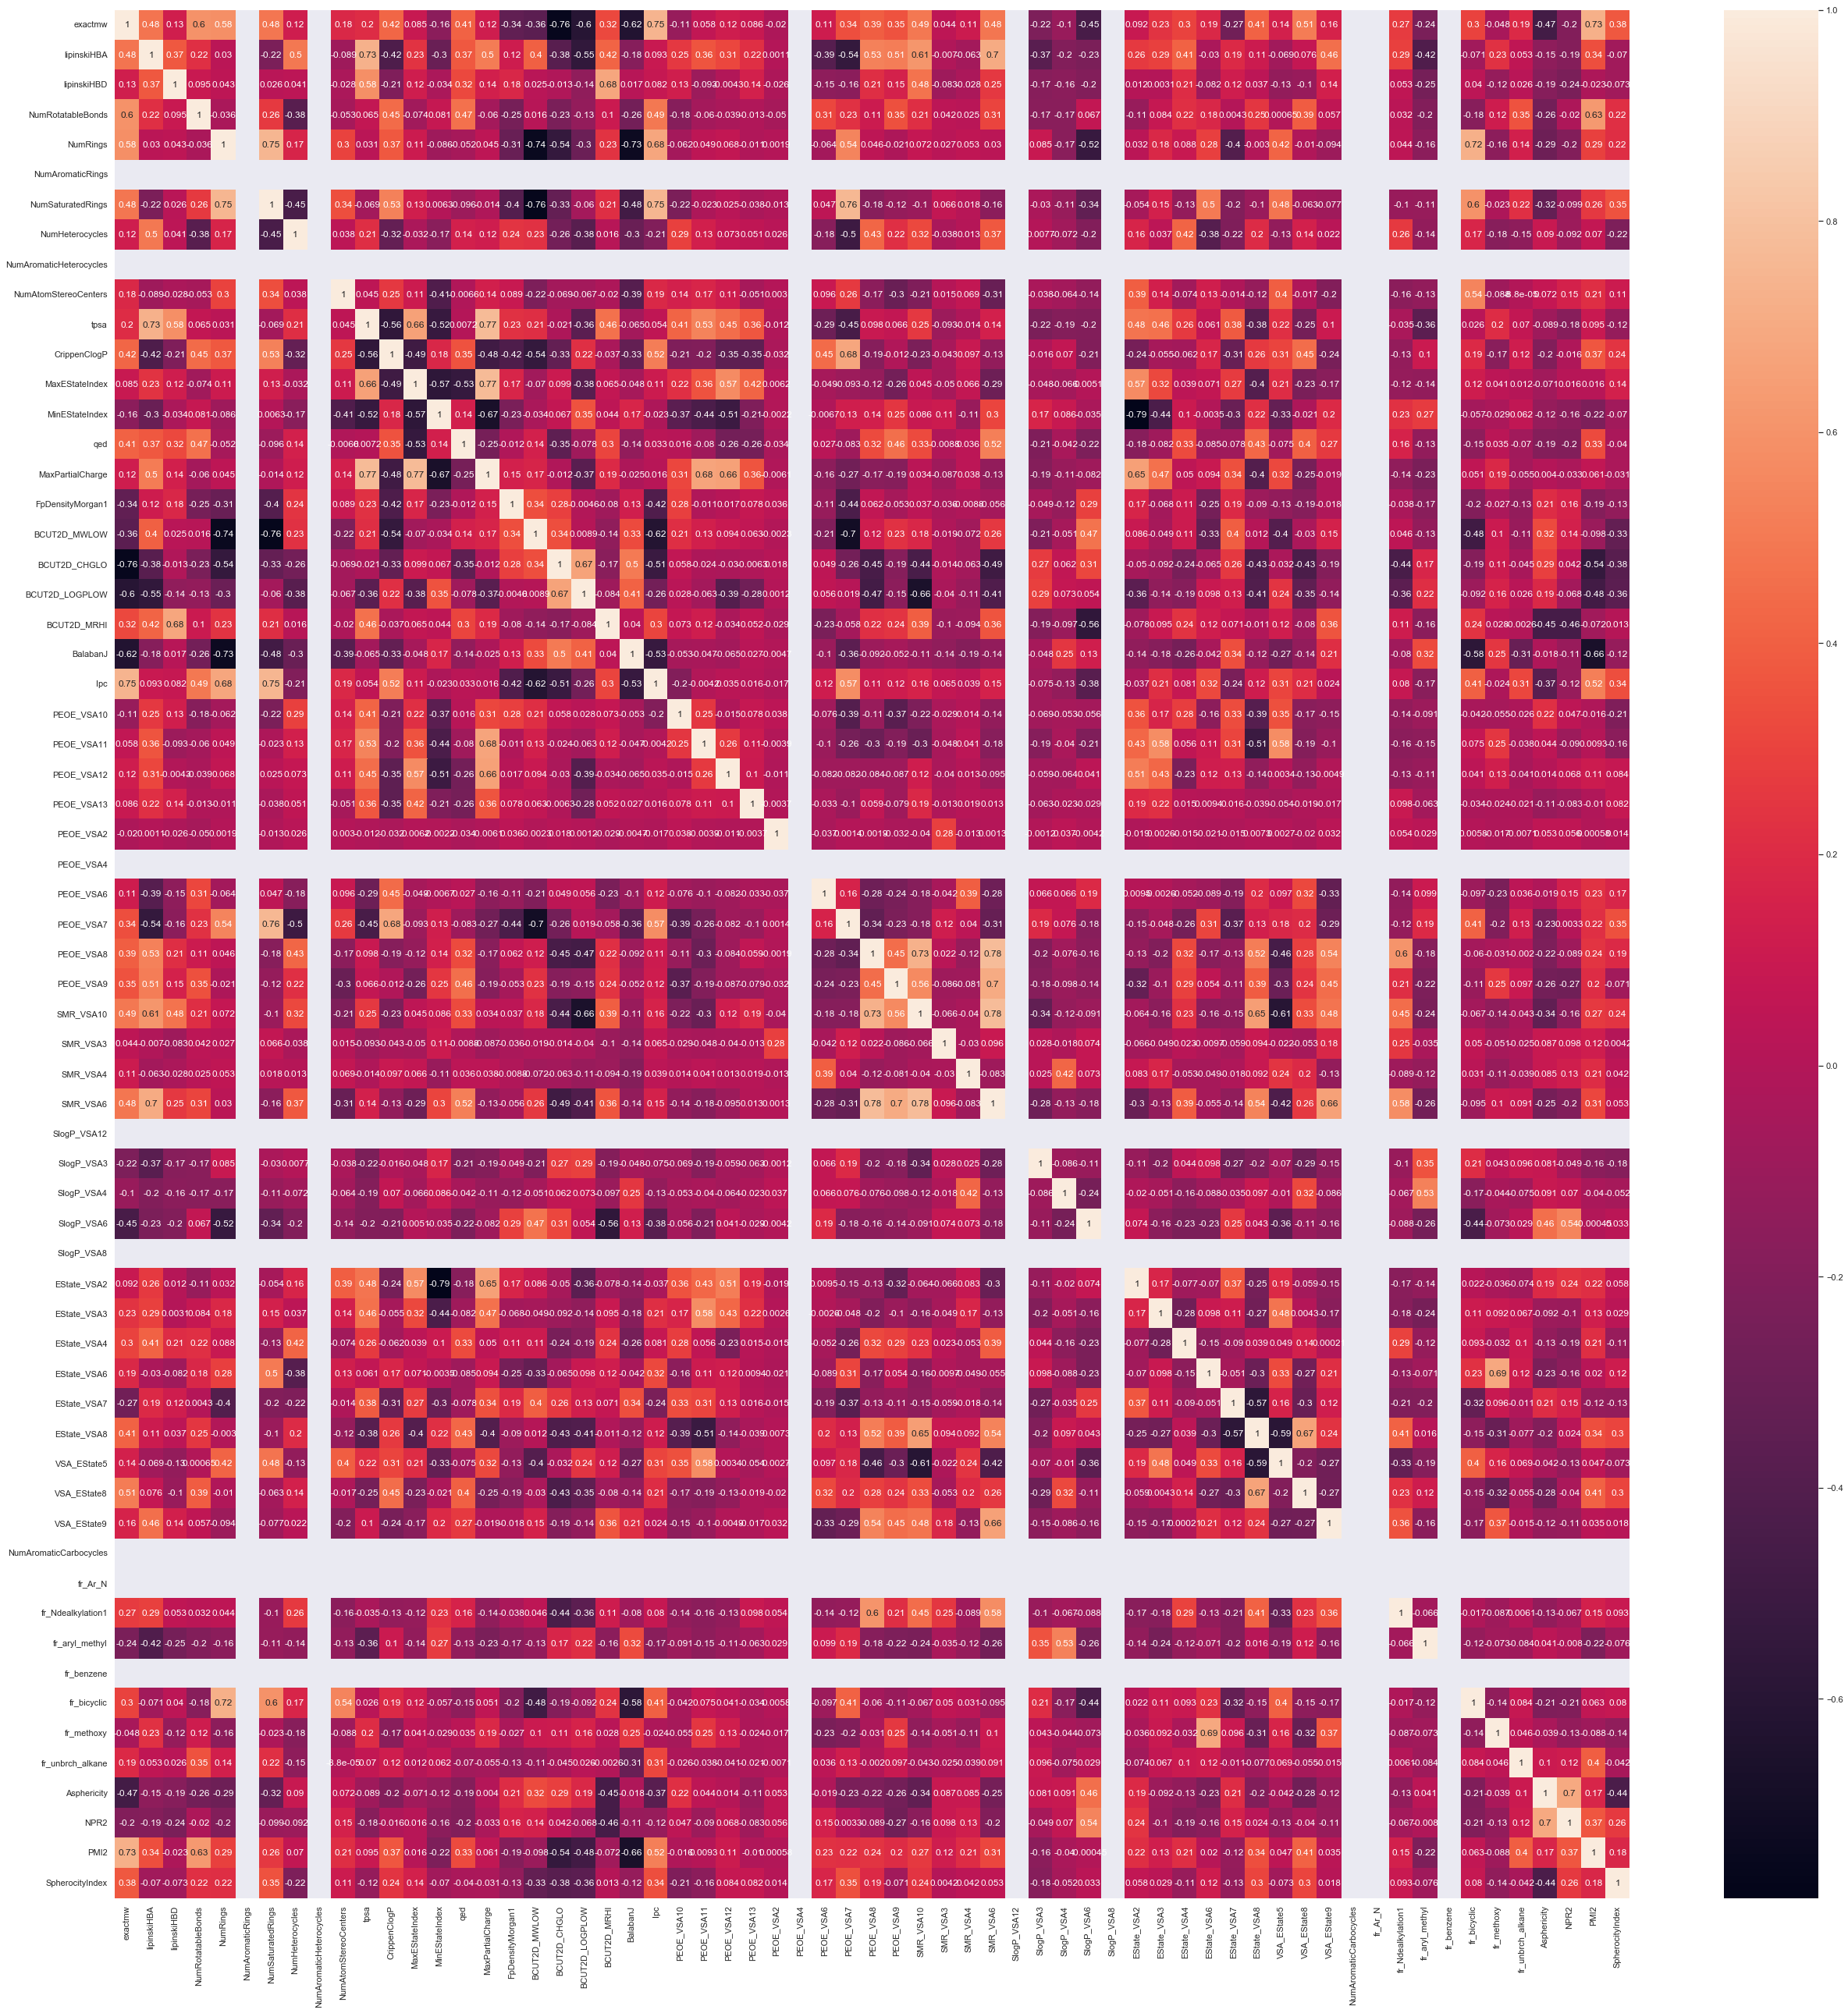

In [195]:
import matplotlib.pyplot as plt

corr = Xdata_btz_uncorr.corr('pearson')
sns.set(rc={"figure.figsize":(36, 36)}) 
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.savefig("../Figures/ERed_features_corr080.png",dpi=300)
# plt.show()


# ERed and Feauture correlation

In [196]:
from scipy import stats
from scipy.stats import norm

In [197]:
target = 'Ered(V)'
descriptors=Xdata_btz_uncorr.columns

In [198]:
corr_ered_feat=[]

C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


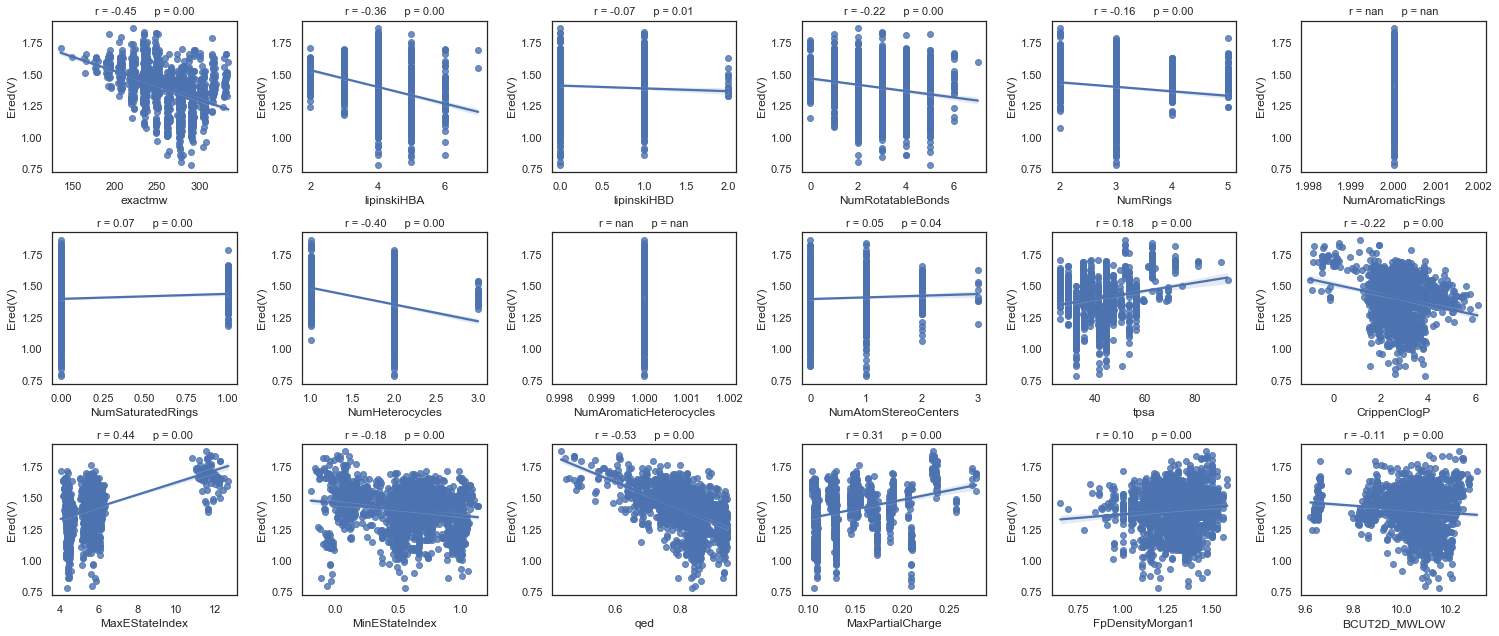

In [199]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([i,stp[0]])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            # print([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

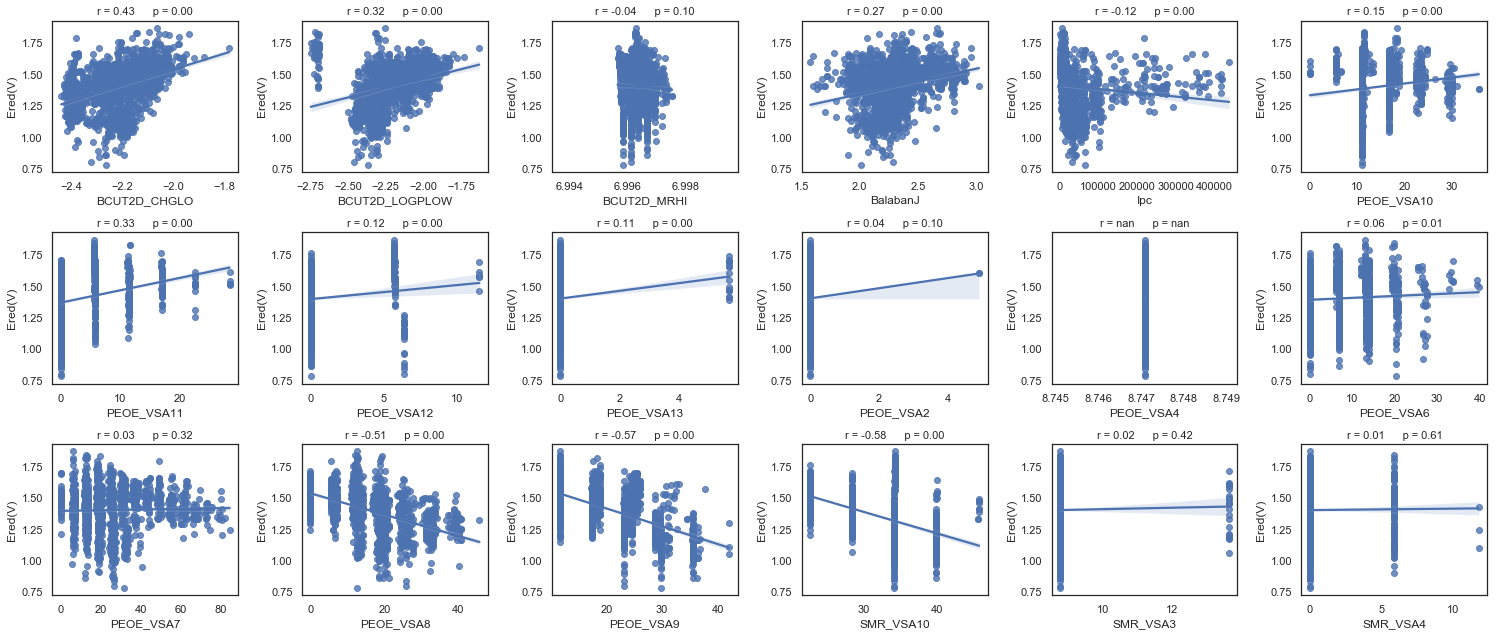

In [200]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])

            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            # corr_ered_feat.append([i,stp[0]])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

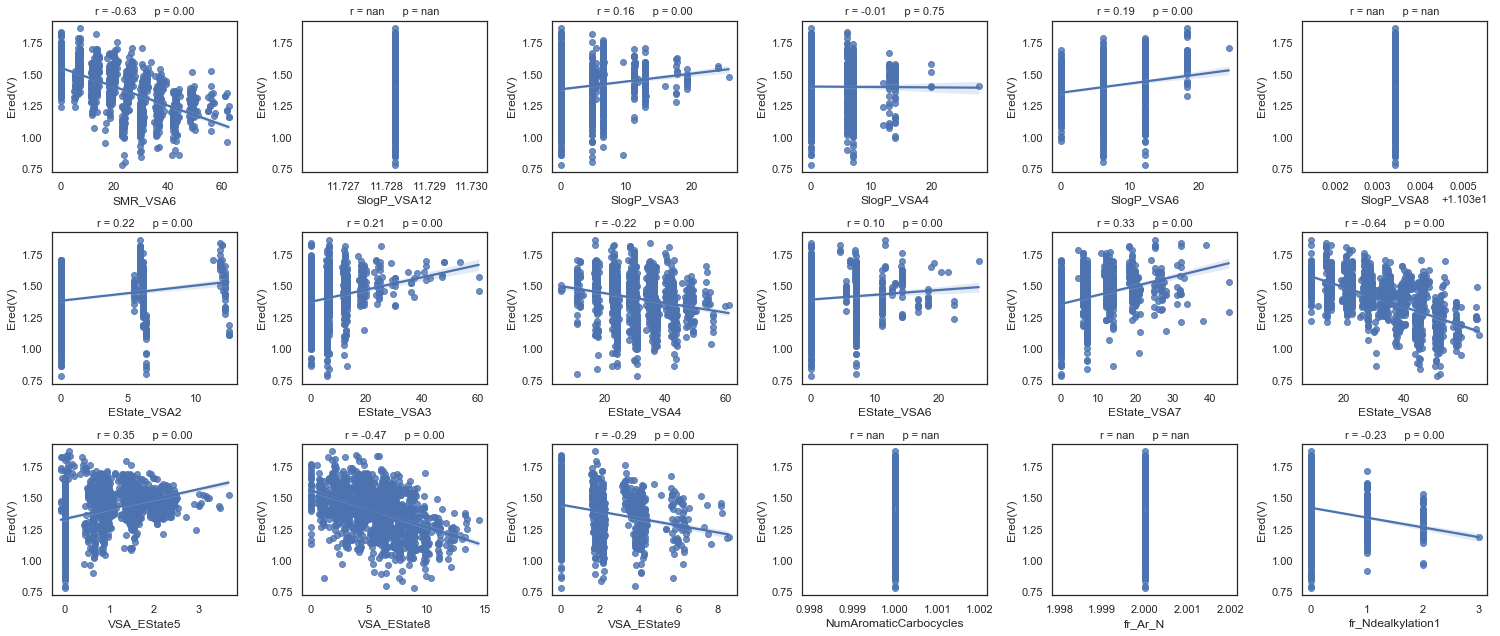

In [201]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            # print([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

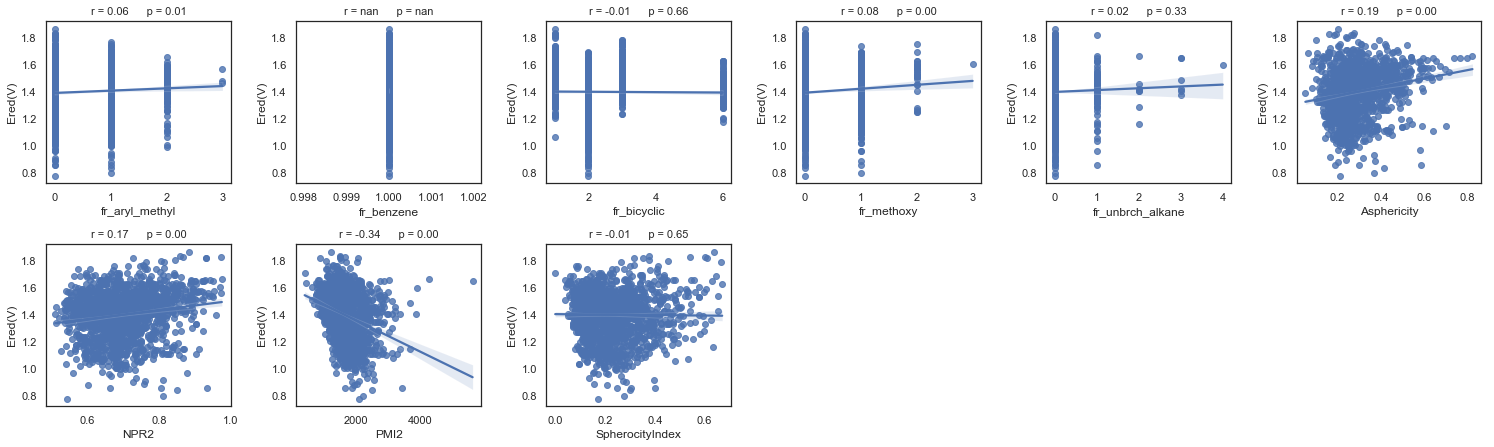

In [202]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

In [205]:
corr_ered_feat=pd.DataFrame(corr_ered_feat,columns=["Descriptors","Pearsons"])

In [215]:
# remove_desc=[desc for i,desc in enumerate(corr_ered_feat["Descriptors"]) if type(desc) is int]
remove_desc2=[i for i,desc in enumerate(corr_ered_feat["Descriptors"]) if type(desc) is int]

In [222]:
corr_ered_feat=corr_ered_feat.drop(remove_desc2)

In [225]:
corr_ered_feat_sorted=corr_ered_feat.dropna(axis=0).sort_values("Pearsons")

# Most dominant features 

In [227]:
df_reducedDescp=pd.concat([corr_ered_feat_sorted[:15],corr_ered_feat_sorted[-10:]])

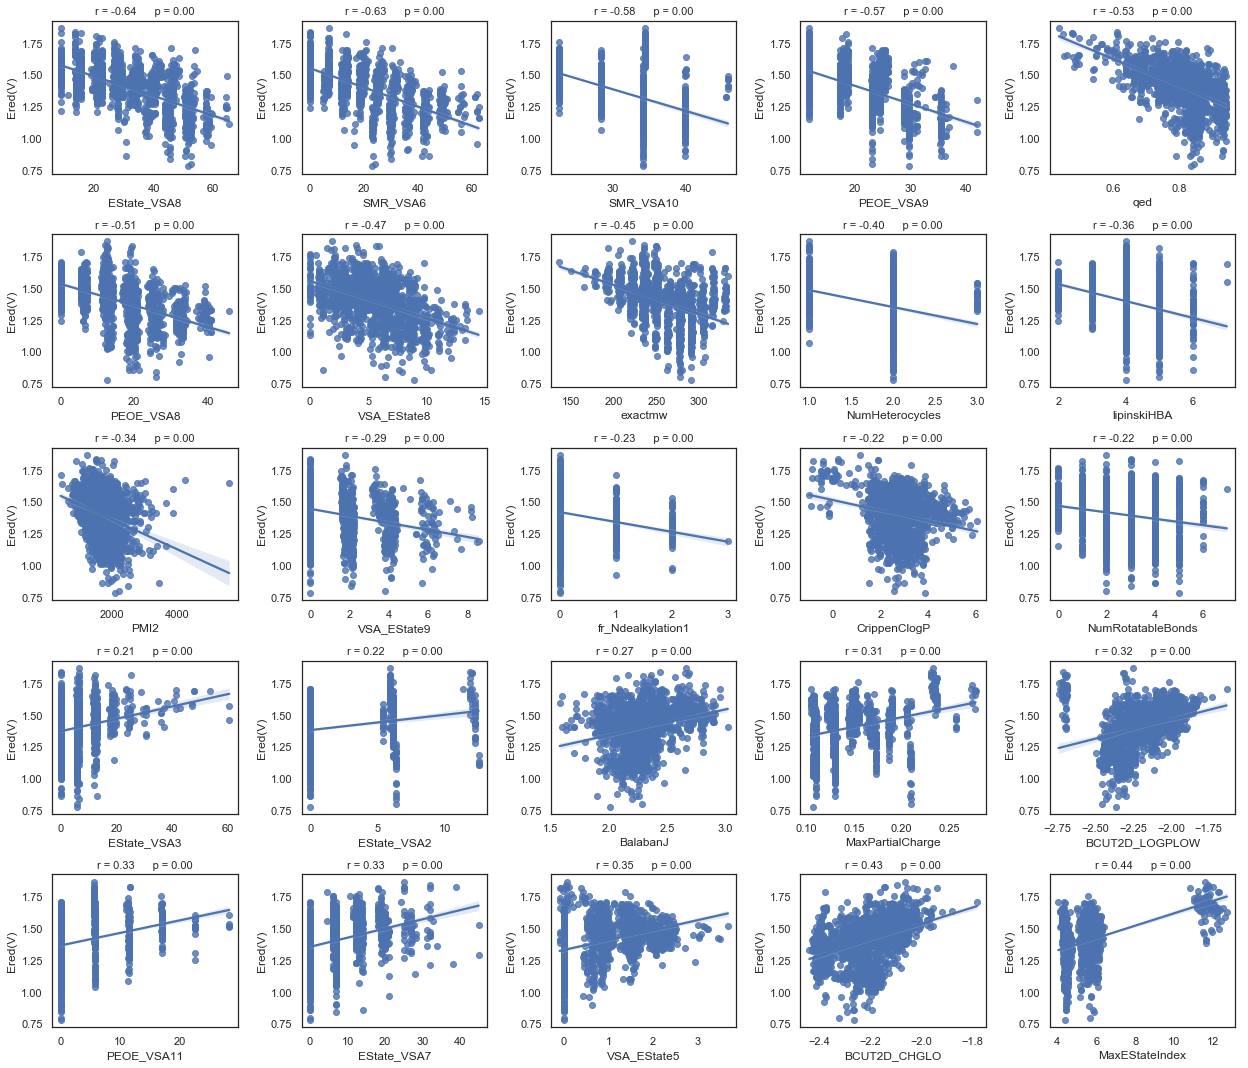

In [230]:
target = 'Ered(V)'
descriptors=df_reducedDescp.Descriptors.to_list()

nr_rows = 5
nr_cols = 5
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  